### PIDs and using wpilib's PID controller - 2021 1212 CJH
---

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import wpilib
from wpilib import controller

### the standard PID control equation looks like this:
## ${u(t)} = K_p e(t) + K_i \int e(t)\, dt + K_d \frac{de}{dt}$
### or, since computers rarely actually do calculus,
## ${u(t)} = K_p e(t) + K_i \sum \limits _{j=1} ^{n} e(t_j){\Delta}t + K_d \frac{(e(t)-e(t-{\Delta}t))}{{\Delta}t}$
Where
* u(t) is the output of the controller - usually power from -100% to 100%
* e(t) is the error = **(setpoint - measured value)** at time t
* and the gains, which the user inputs to the model, are
  * Kp is the proportional gain - the farther away from the setpoint, the more power is applied (like a spring)
  * Ki is the integral gain - the sum of all of the old errors times the time between measurements
  * Kd is the derivative gain - looks at the change in the error **(error now - previous error)** and slows you down - (like a shock absorber)


### Do some simple tests with static models

In [19]:
def clamp(value: float, bottom: float, top: float) -> float:
    return max(bottom, min(value, top))

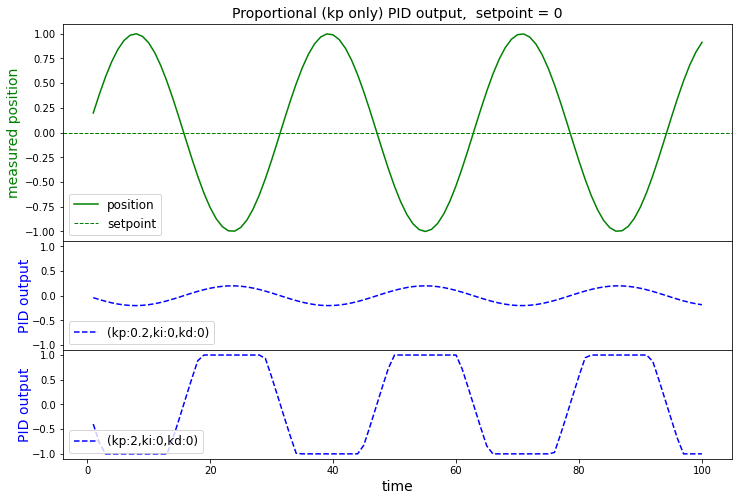

In [46]:
# Simple data to display in various forms
kp, ki, kd = 2, 0, 0
def get_response(kp, ki, kd):
    test_control = controller.PIDController(Kp=kp, Ki=ki, Kd=kd)
    test_control.setIntegratorRange(-0.5, 0.5)
    pid_response = [clamp(test_control.calculate(ix), -1, 1) for ix in pos]
    return pid_response

# make some dummy data
x = np.linspace(1,100,100)
pos = np.sin(x/5)

#start the figure
fig = plt.figure(figsize=(12,8))
# set height ratios for subplots
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 

# the first subplot
ax1 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
line_1, = ax1.plot(x, pos, color='g', label='position')
ax1.axhline(y=0, color='g', lw=1, linestyle='--', label='setpoint')

# the second subplot
# shared axis X
ax2 = plt.subplot(gs[1], sharex = ax1)
kp, ki, kd = 0.2, 0, 0
pid_response = get_response(kp, ki, kd)
line_2, = ax2.plot(x, pid_response, color='b', linestyle='--', label=f'(kp:{kp},ki:{ki},kd:{kd})')
#plt.setp(ax1.get_xticklabels(), visible=False)

# the third subplot
# shared axis X
ax3 = plt.subplot(gs[2], sharex = ax1)
kp, ki, kd = 2, 0, 0
pid_response = get_response(kp, ki, kd)
line_3, = ax3.plot(x, pid_response, color='b', linestyle='--', label=f'(kp:{kp},ki:{ki},kd:{kd})')

# format the chart
ax1.set_ylabel('measured position', color='g', fontsize=14)
ax2.set_ylabel('PID output', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
ax3.set_ylabel('PID output', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
ax3.set_xlabel(f'time', fontsize=14)
ax2.set_ylim([-1.1,1.1])
ax2.set_xlabel(f'time', fontsize=14)
ax1.set_title(f'Proportional (kp only) PID output,  setpoint = 0', fontsize=14)
#ax1.legend((line_1, line_2), ('position', f'(kp:{kp},ki:{ki},kd:{kd})'), loc='lower left', prop={'size': 12})
[ax.legend(loc='lower left', prop={'size': 12}) for ax in [ax1, ax2, ax3]]
# remove vertical gap between subplots
plt.subplots_adjust(hspace=0)
plt.show()

### How about an elevator acting under gravity

In [21]:
def calc_pids(kp=kp, ki=ki, kd=kd, setpoint=7, y_0=0, motor_scale=2):
# set up the array of times
    x = np.linspace(0,4,100) # ten seconds of data
    dt = x[1]-x[0]

    # set the initial conditions
    y = y_0
    y_t = 0

    setpoint = setpoint
    sum_error = 0
    previous_error = 0
    a = 10

    # initialize the two arrays we calculate
    position = []
    velocity = []
    accel = []
    pid = []

    # calculate the error and position at each point
    for t in x:
        error = setpoint - y
        sum_error += error
        output = kp * error + ki * sum_error * dt + kd * (error-previous_error)/dt
        output = clamp(output, -1, 1)
        previous_error = error

        # forces, velocity, position
        y_tt = -a + motor_scale * a * output  # fake it, make the motor 2x gravity at full power
        y_t += y_tt * dt  # velocity is at
        y += y_t * dt
        y = 0 if y < 0 else y
        y_t = 0 if y <= 0 else y_t

        position.append(y)
        velocity.append(y_t)
        pid.append(output)
        accel.append(y_tt)
        
    return x, position, velocity, pid, accel

def plot_elevator(kp=kp, ki=ki, kd=kd, setpoint=7, y_0=0, motor_scale=2, label='',):
    
    x, position, velocity, pid, accel = calc_pids(kp=kp, ki=ki, kd=kd, setpoint=setpoint, y_0=y_0, motor_scale=motor_scale)
    #start the figure
    fig = plt.figure(figsize=(12,8))
    # set height ratios for subplots
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1]) 

    # the first subplot
    ax1 = plt.subplot(gs[0])
    line_1, = ax1.plot(x, position, color='g', label='position')
    ax1.axhline(y=setpoint, color='g', lw=1, linestyle='--', label='setpoint')

    ax4 = plt.subplot(gs[3])
    line_4, = ax4.plot(x, pid, color='k', label='PID')


    ax2 = plt.subplot(gs[1])
    line_2, = ax2.plot(x, velocity, color='b', label='velocity')
    ax2.axhline(y=0, color='b', lw=1, linestyle='--', label='')

    ax3 = plt.subplot(gs[2])
    line_3, = ax3.plot(x, accel, color='r', label='acceleration')

    # format the chart
    ax1.set_title(f'{label} (kp={kp},ki={ki},kd={kd}) PID output,  setpoint = {setpoint}', fontsize=14)
    ax1.set_ylabel('measured position', color='g', fontsize=14)
    ax2.set_ylabel('velocity', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax3.set_ylabel('accel', color='r', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_ylabel('PID', color='k', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_xlabel(f'time', fontsize=14)
    ax3.set_xticks([])
    
    [ax.legend(loc='lower right', prop={'size': 12}) for ax in [ax1, ax2, ax3, ax4]]
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=0)

    return fig

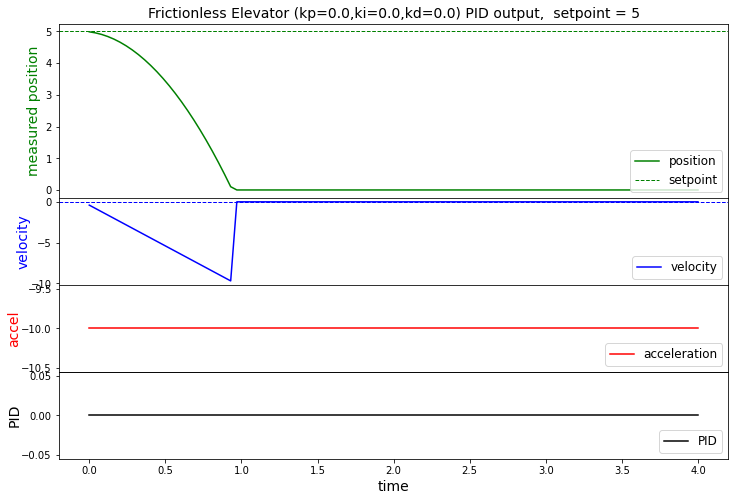

In [45]:
# set the gains
kp, ki, kd = 0.0, 0.0, 0.0
#kp, ki, kd = 0.9, 0.2, 0.1
#kp, ki, kd = 1.8, 0.5, 0.2
setpoint = 5
y_0 = 5
_ = plot_elevator(kp=kp, ki=ki, kd=kd, setpoint=setpoint, y_0=y_0, label='Frictionless Elevator', motor_scale=2)

#### The docstring and various aspects of the PIDController class are explored below
* instantiate by passing three gains, e.g. `test_control = controller.PIDController(Kp=0.01, Ki=0, Kd=0)`
* setpoint is 0 by default, change by `.setSetpoint()`
* get the output from `calculate(current_measurement)`  *you feed it POSITION, not error!*
* it does not clamp to ±1 so you have to do that yourself
* you can force the the integral to be in a range with `setIntegratorRange(min, max)`
* use in combination with the feedforward for better control
https://docs.wpilib.org/en/stable/docs/software/advanced-controls/controllers/feedforward.html

In [23]:
controller.PIDController?

Docstring:      Implements a PID control loop.
Init docstring:
__init__(self: wpilib.controller._controller.PIDController, Kp: float, Ki: float, Kd: float, period: seconds = 0.02) -> None

Allocates a PIDController with the given constants for Kp, Ki, and Kd.

:param Kp:     The proportional coefficient.
:param Ki:     The integral coefficient.
:param Kd:     The derivative coefficient.
:param period: The period between controller updates in seconds. The
               default is 20 milliseconds. Must be non-zero and positive.
File:           c:\users\cjhill\miniconda3\envs\robo2021\lib\site-packages\wpilib\controller\_controller.cp38-win_amd64.pyd
Type:           pybind11_type
Subclasses:     


In [24]:
test_control = controller.PIDController(Kp=0.01, Ki=0, Kd=0)

In [25]:
test_control.getSetpoint()

0.0

In [26]:
test_control.getPositionError()

0.0

In [27]:
test_control.calculate?

Docstring:
calculate(*args, **kwargs)
Overloaded function.

1. calculate(self: wpilib.controller._controller.PIDController, measurement: float) -> float

Returns the next output of the PID controller.

:param measurement: The current measurement of the process variable.

2. calculate(self: wpilib.controller._controller.PIDController, measurement: float, setpoint: float) -> float

Returns the next output of the PID controller.

:param measurement: The current measurement of the process variable.
:param setpoint:    The new setpoint of the controller.
Type:      method


In [28]:
# let's see what the PID controller gives us
controller_attributes = [name for name in dir(test_control) if '_' not in name]
_ = [print(attrib, end=', ') if (ix+1)%8!=0 else print(attrib, end='\n') for ix, attrib in enumerate(controller_attributes) ]

atSetpoint, calculate, disableContinuousInput, enableContinuousInput, getD, getI, getP, getPeriod
getPositionError, getSetpoint, getVelocityError, initSendable, isContinuousInputEnabled, reset, setD, setI
setIntegratorRange, setP, setPID, setSetpoint, setTolerance, 

In [48]:
2 * (1,3)

(1, 3, 1, 3)